In [1]:
# use for some charts and verification
!pip install PyPortfolioOpt

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import math
from numpy.linalg import inv

# charting
import seaborn as sns
import matplotlib.pyplot as plt

# Data sourcing
import pandas_datareader as pdr
import yfinance as yf

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Regressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import statsmodels.api as sm

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#optimization
import statsmodels.api as sm
import pypfopt


#Import Model Packages
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers

## Step 2

From GWP 2,  the portfolio that has the best sharpe ratio is:

*   PLTR
*   LI
*   NUE
*   CLSK
*   NVDA

In [3]:
# Download the data and use only the Adjusted Close price
tickers = [ 'PLTR', 'LI',	'NUE', 	'CLSK', 	'NVDA']


start_date = '2021-04-14'
end_date = '2022-12-31'

tic_data = yf.download(tickers, start=start_date, end=end_date)
stock_data = tic_data['Adj Close']
stock_data.to_csv ("stock_data.csv")
daily_returns = stock_data.pct_change().dropna()
daily_returns.to_csv ("daily_returns.csv")

[*********************100%%**********************]  5 of 5 completed


In [4]:
# Calculate annualized returns and covariance
annual_returns = daily_returns.mean() * 252
cova = daily_returns.cov() * 252
annual_returns, cova

(Ticker
 CLSK   -0.905282
 LI      0.282548
 NUE     0.417460
 NVDA    0.130912
 PLTR   -0.553305
 dtype: float64,
 Ticker      CLSK        LI       NUE      NVDA      PLTR
 Ticker                                                  
 CLSK    0.926347  0.326406  0.129679  0.322693  0.386677
 LI      0.326406  0.611696  0.056617  0.171443  0.215347
 NUE     0.129679  0.056617  0.205459  0.088040  0.079610
 NVDA    0.322693  0.171443  0.088040  0.313842  0.229183
 PLTR    0.386677  0.215347  0.079610  0.229183  0.406862)

### Library of Common Functions

In [5]:
# Function to calculate portfolio statistics
def portfolio_stats(weights, returns, covariance):

    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
    return portfolio_return, portfolio_volatility

def compute_sortino_ratio (daily_returns, weights, threshold = 0, risk_free_rate = 0.02):

    daily_weighted_returns = np.dot(daily_returns, weights)
    mean_data_annualized = daily_weighted_returns.mean() * 252
    #Always lower values than treshold
    downside = daily_weighted_returns[daily_weighted_returns<0]
    std = downside.std() *  (252**0.5)
    sortino_ratio  = (mean_data_annualized - threshold)/std
    return sortino_ratio

### Marcenko-Pastur functions

sse:23321.84431817684
sse:23321.843385303087
sse:7613.429129795077
sse:7613.429236899993
found errPDFs0.99999


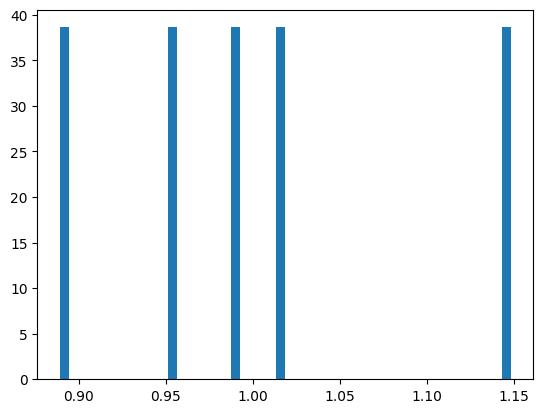

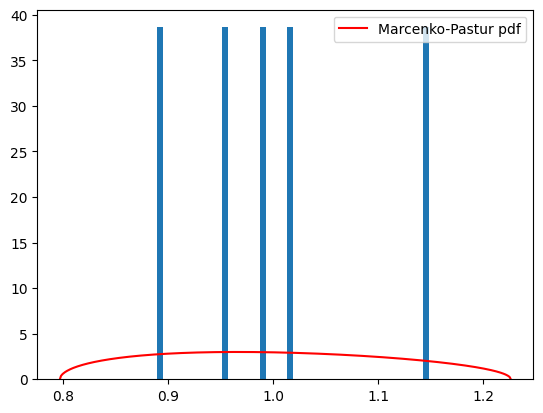

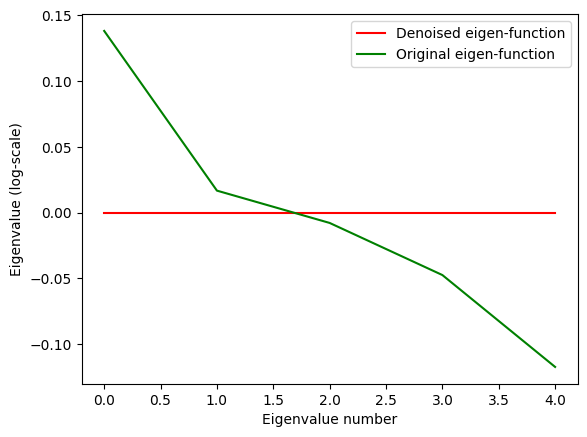

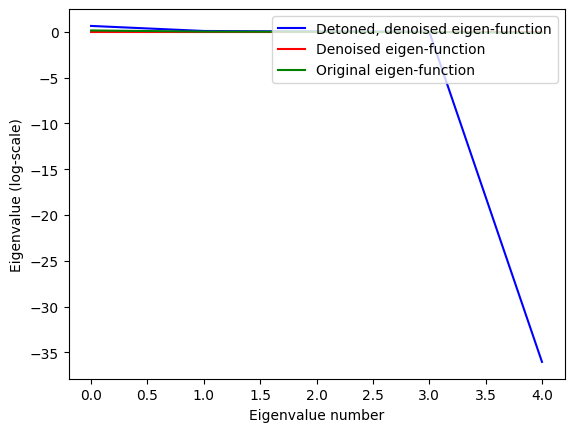

In [6]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pylab as plt
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

#snippet 2.1
#Marcenko-Pastur pdf
#q=T/N
def mpPDF(var, q, pts):
    eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2 # calc lambda_minus, lambda_plus
    eVal = np.linspace(eMin, eMax, pts) #Return evenly spaced numbers over a specified interval. eVal='lambda'
    #Note: 1.0/2*2 = 1.0 not 0.25=1.0/(2*2)
    pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 #np.allclose(np.flip((eMax-eVal)), (eVal-eMin))==True
    pdf = pd.Series(pdf, index=eVal)
    return pdf

#snippet 2.2
#Test Marcenko-Pastur Thm
def getPCA(matrix):
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eig(matrix) #complex Hermitian (conjugate symmetric) or a real symmetric matrix.
    indices = eVal.argsort()[::-1] #arguments for sorting eval desc
    eVal,eVec = eVal[indices],eVec[:,indices]
    eVal = np.diagflat(eVal) # identity matrix with eigenvalues as diagonal
    return eVal,eVec

def fitKDE(obs, bWidth=.15, kernel='gaussian', x=None):
    #Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    #print(len(obs.shape) == 1)
    if len(obs.shape) == 1: obs = obs.reshape(-1,1)
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    #print(x is None)
    if x is None: x = np.unique(obs).reshape(-1,1)
    #print(len(x.shape))
    if len(x.shape) == 1: x = x.reshape(-1,1)
    logProb = kde.score_samples(x) # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

#snippet 2.3
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov

#snippet 2.4 - fitting the marcenko-pastur pdf - find variance
#Fit error
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse

# find max random eVal by fitting Marcenko's dist
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

# code snippet 2.5 - denoising by constant residual eigenvalue
# Remove noise from corr by fixing random eigenvalue
# Operation invariante to trace(Correlation)
# The Trace of a square matrix is the _Sum_ of its eigenvalues
# The Determinate of thematrix is the _Product_ of its eigenvalues
def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts) #all but 0..i values equals (1/N-i)sum(eVal_[i..N]))
    eVal_ = np.diag(eVal_) #square matrix with eigenvalues as diagonal: eVal_.I
    cov1 = np.dot(eVec, eVal_).dot(eVec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    return cov1

def denoisedCov(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts) #all but 0..i values equals (1/N-i)sum(eVal_[i..N]))
    eVal_ = np.diag(eVal_) #square matrix with eigenvalues as diagonal: eVal_.I
    corr1 = np.dot(eVec, eVal_).dot(eVec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    corr1 = cov2corr(corr1) # Rescaling the correlation matrix to have 1s on the main diagonal
    return corr1

# code snippet 2.6 - detoning
# ref: mlfinlab/portfolio_optimization/risk_estimators.py
# This method assumes a sorted set of eigenvalues and eigenvectors.
# The market component is the first eigenvector with highest eigenvalue.
# it returns singular correlation matrix:
# "the detoned correlation matrix is singualar, as a result of eliminating (at least) one eigenvector."
# Page 32
def detoned_corr(corr, eigenvalues, eigenvectors, market_component=1):
    """
    De-tones the de-noised correlation matrix by removing the market component.
    The input is the eigenvalues and the eigenvectors of the correlation matrix and the number
    of the first eigenvalue that is above the maximum theoretical eigenvalue and the number of
    eigenvectors related to a market component.
    :param corr: (np.array) Correlation matrix to detone.
    :param eigenvalues: (np.array) Matrix with eigenvalues on the main diagonal.
    :param eigenvectors: (float) Eigenvectors array.
    :param market_component: (int) Number of fist eigevectors related to a market component. (1 by default)
    :return: (np.array) De-toned correlation matrix.
    """

    # Getting the eigenvalues and eigenvectors related to market component
    eigenvalues_mark = eigenvalues[:market_component, :market_component]
    eigenvectors_mark = eigenvectors[:, :market_component]

    # Calculating the market component correlation
    corr_mark = np.dot(eigenvectors_mark, eigenvalues_mark).dot(eigenvectors_mark.T)

    # Removing the market component from the de-noised correlation matrix
    corr = corr - corr_mark

    # Rescaling the correlation matrix to have 1s on the main diagonal
    corr = cov2corr(corr)

    return corr


if __name__ == '__main__':
    # code snippet 2.2 - marcenko-pastur pdf explains eigenvalues of random matrix x

    x = daily_returns
    N = stock_data.shape[0]
    #cor = np.corrcoef(x, rowvar=0) # cor.shape = (1000,1000). If rowvar=1 - row represents a var, with observations in the columns.
    eVal0 , eVec0 = getPCA( cova )
    pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
    pdf1 = fitKDE(np.diag(eVal0), bWidth=.005) #empirical pdf

    # code snippet 2.3 - random matrix with signal
    alpha, nCols, nFact, q = .995, stock_data.shape[1], 5, (int) (stock_data.shape[0]/stock_data.shape[1])
    pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
    cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0) #size = (1000*10,1000)
    cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise + signal
    corr0 = cov2corr(cov)
    eVal01, eVec01 = getPCA(corr0)
    #pdf2 = fitKDE(np.diag(eVal01), bWidth=.15) #empirical pdf

    # Figure 2.1 Plot empirical:KDE and Marcenko-Pastur, and histogram
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues

    #plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
    #plt.plot(pdf1.keys(), pdf1, color='g', label="Empirical:KDE")
    #plt.plot(x_range, pdf2, color='b', label="Eigenvalues of random-matrix with signal")
    #plt.legend(loc="upper right")
    #plt.show()

    # code snippet 2.4 - fitting the marcenko-pastur pdf - find variance
    eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)
    nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)

    #code snippet 2.3 - with random matrix with signal
    ######################
    # Figure 2.1 Plot empirical:KDE and Marcenko-Pastur, and histogram
    pdf0 = mpPDF(var0, q=x.shape[0]/float(x.shape[1]), pts=N)
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues

    plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
    #plt.plot(pdf1.keys(), pdf1, color='g', label="Empirical:KDE")
    #plt.plot(x_range, pdf2, color='b', label="Eigenvalues of random-matrix with signal")
    plt.legend(loc="upper right")
    plt.show()
    ######################

    # code snippet 2.5 - denoising by constant residual eigenvalue
    corr1 = denoisedCorr(eVal01, eVec01, nFacts0)
    eVal1, eVec1 = getPCA(corr1)

    denoised_eigenvalue = np.diag(eVal1)
    eigenvalue_prior = np.diag(eVal01)
    plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
    plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
    plt.xlabel("Eigenvalue number")
    plt.ylabel("Eigenvalue (log-scale)")
    plt.legend(loc="upper right")
    plt.show()

    corr_detoned_denoised = detoned_corr(corr1, eVal1, eVec1)

    eVal1_detoned, eVec1_detoned = getPCA(corr_detoned_denoised)
    detoned_denoised_eigenvalue = np.diag(eVal1_detoned)
    denoised_eigenvalue = np.diag(eVal1)
    eigenvalue_prior = np.diag(eVal01)

    plt.plot(range(0, len(detoned_denoised_eigenvalue)), np.log(detoned_denoised_eigenvalue), color='b', label="Detoned, denoised eigen-function")
    plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
    plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
    plt.xlabel("Eigenvalue number")
    plt.ylabel("Eigenvalue (log-scale)")
    plt.legend(loc="upper right")
    plt.show()

### Calculate MVO Portfolio

In [7]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA, plotting

In [8]:
ef = EfficientFrontier(annual_returns, cova, weight_bounds=(0, 1))
aw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print (cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('CLSK', 0.0), ('LI', 0.12106), ('NUE', 0.87894), ('NVDA', 0.0), ('PLTR', 0.0)])
Expected annual return: 40.1%
Annual volatility: 42.4%
Sharpe Ratio: 0.90


(0.4011270431634694, 0.42395481260619766, 0.8989803437317976)

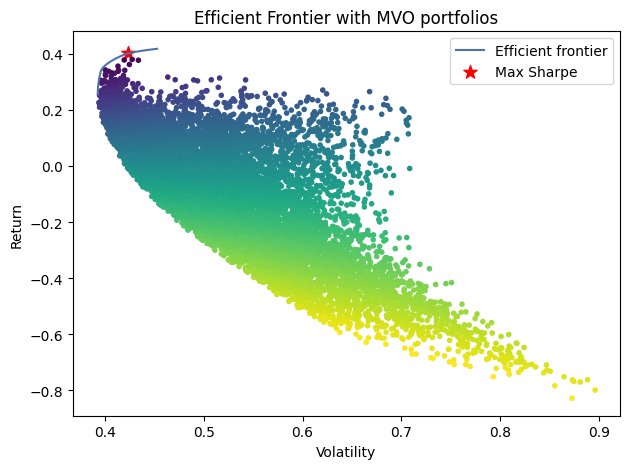

In [9]:
ef = EfficientFrontier(annual_returns, cova, weight_bounds=(0, 1))
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, sr = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with MVO portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("2_mvp_ef_scatter.png", dpi=200)
plt.show()

In [10]:
print ("--------------MVO------------------\n")
print (f"Portfolio Return: {ret_tangent:.2%}")
print (f"Portfolio Vol: {std_tangent:.2%}")
print ("Sharpe Ratio: ", sr)
mvo_weights = np.fromiter(cleaned_weights.values(), dtype=float)
sortio_mvo = compute_sortino_ratio (daily_returns, mvo_weights)
#sortio_mvo
print ("Sortino Ratio: ", sortio_mvo)

--------------MVO------------------

Portfolio Return: 40.11%
Portfolio Vol: 42.40%
Sharpe Ratio:  0.8989803437317976
Sortino Ratio:  1.4617240340438766


### Calcuate Return form Denoised covariance matrix

In [11]:

corr0 = cov2corr(cova)
eVal01, eVec01 = getPCA(corr0)
# code snippet 2.4 - fitting the marcenko-pastur pdf - find variance
eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)
nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)
cov_denoised = denoisedCov(eVal01, eVec01, nFacts0)

sse:23675.25890688487
sse:23675.257603039398
sse:6150.947198982178
sse:6150.947197724025
sse:6150.900896700822
sse:6150.900897364337
sse:6150.882988510834
sse:6150.8829885137875
sse:6150.882988156556
sse:6150.882988156561
found errPDFs0.9989677597083332


In [12]:
ef = EfficientFrontier(annual_returns, cov_denoised, weight_bounds=(0, 1))
aw_weights = ef.max_sharpe()
cleaned_weights_denoised = ef.clean_weights()
print (cleaned_weights_denoised)
ef.portfolio_performance(verbose=True)

OrderedDict([('CLSK', 0.0), ('LI', 0.30619), ('NUE', 0.69381), ('NVDA', 0.0), ('PLTR', 0.0)])
Expected annual return: 37.6%
Annual volatility: 84.1%
Sharpe Ratio: 0.42


(0.37615119863079105, 0.8405996141109635, 0.423687083186999)

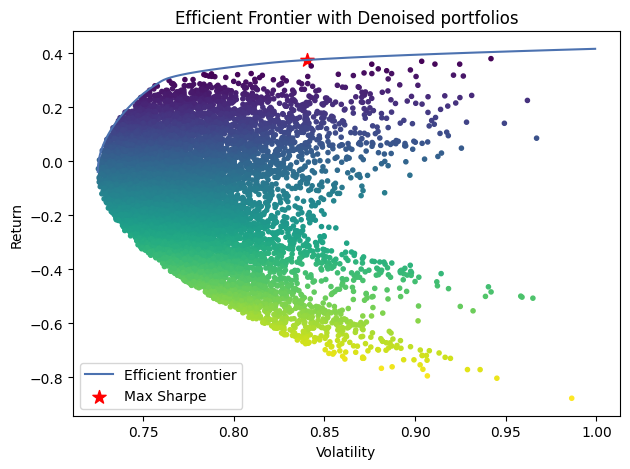

In [13]:
ef = EfficientFrontier(annual_returns, cov_denoised, weight_bounds=(0, 1))
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, sr = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ cov_denoised @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with Denoised portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("2_hrp_ef_scatter.png", dpi=200)
plt.show()



In [14]:
print ("--------------Denoised Covariance Matrix------------------\n")
print (f"Portfolio Return: {ret_tangent:.2%}")
print (f"Portfolio Vol: {std_tangent:.2%}")
print ("Sharpe Ratio: ", sr)

--------------Denoised Covariance Matrix------------------

Portfolio Return: 37.62%
Portfolio Vol: 84.06%
Sharpe Ratio:  0.423687083186999


### Calculate HRP Return: Apply HRP Clustering Algorithm - Library Based

In [15]:
from pypfopt import HRPOpt

In [16]:
hrp = HRPOpt(daily_returns)
hrp.optimize()
hrp_weights = hrp.clean_weights()
hrp_weights

OrderedDict([('CLSK', 0.08385),
             ('LI', 0.16297),
             ('NUE', 0.48521),
             ('NVDA', 0.15128),
             ('PLTR', 0.11669)])

In [17]:
daily_returns

Ticker,CLSK,LI,NUE,NVDA,PLTR
Date,,,,,
2021-04-15,-0.012658,-0.067299,-0.002024,0.056310,-0.023207
2021-04-16,-0.100665,-0.020325,0.007605,-0.013928,-0.029374
2021-04-19,-0.072334,-0.001556,-0.000755,-0.034611,-0.023587
2021-04-20,-0.031303,-0.004675,-0.011959,-0.012401,-0.007293
2021-04-21,0.093420,0.032359,0.021531,0.012474,0.039027
...,...,...,...,...,...
2022-12-23,-0.034314,-0.081253,-0.006063,-0.008671,-0.004747
2022-12-27,-0.045685,-0.012254,0.003380,-0.071353,-0.046105
2022-12-28,-0.037234,-0.005933,-0.017211,-0.006019,0.011667


In [18]:
hrp.portfolio_performance(verbose=True);

Expected annual return: 12.8%
Annual volatility: 41.8%
Sharpe Ratio: 0.26


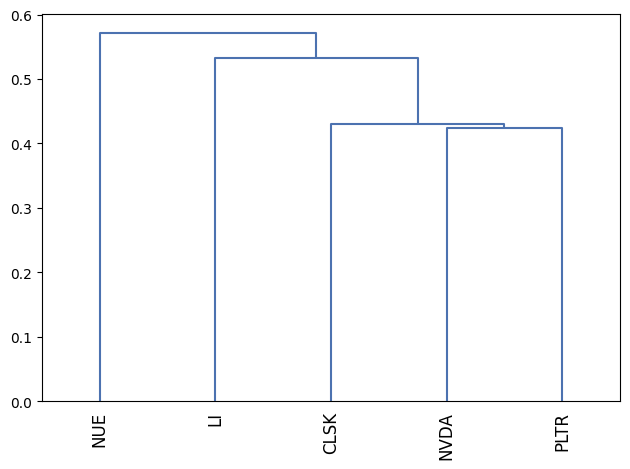

In [19]:
plotting.plot_dendrogram(hrp);

### Calculate MVO & HRP Returns - From First principles

In [20]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

#Calulate linkage
dist = correlDist(corr0)
link = linkage(dist, 'ward')
link[0]

<ipython-input-20-83be401dd6c5>:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(dist, 'ward')


array([3.        , 4.        , 0.60019047, 2.        ])

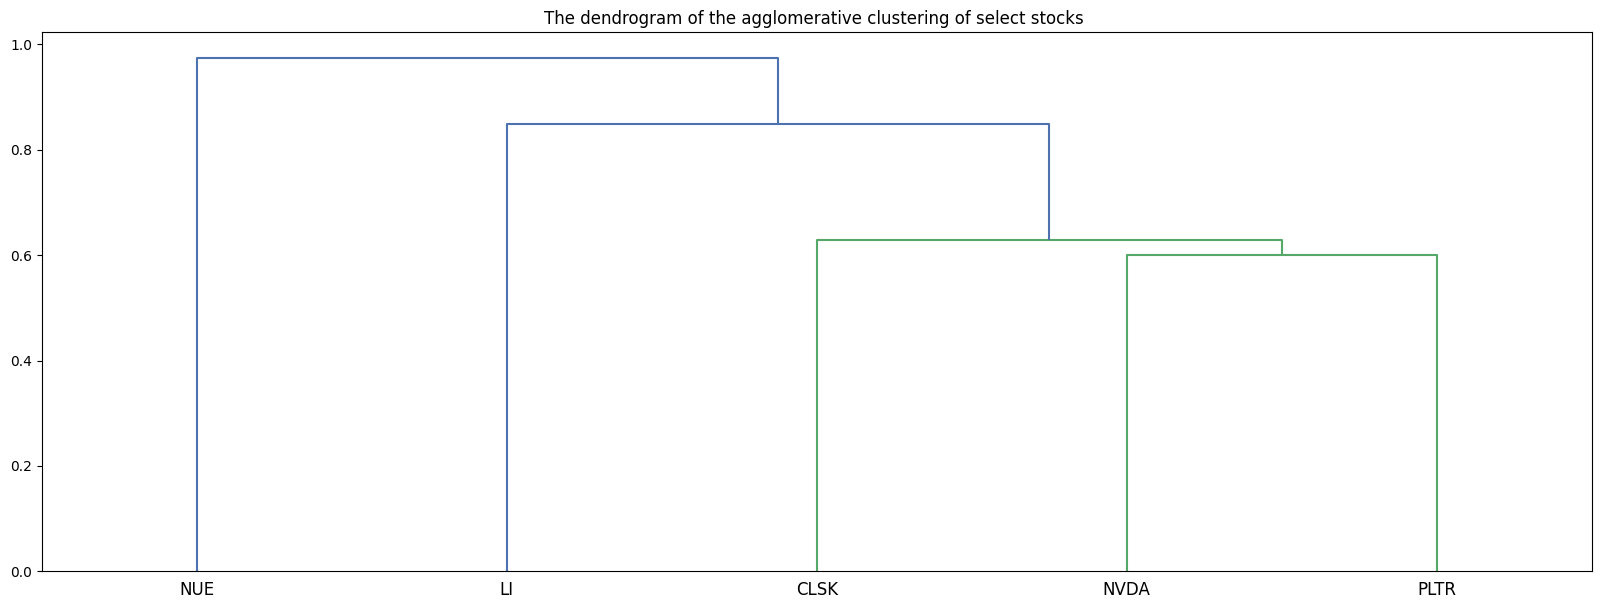

In [21]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
plt.title("The dendrogram of the agglomerative clustering of select stocks ")
dendrogram(link,labels = stock_data.columns)
plt.show()

In [22]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx._append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [23]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [24]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)


    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index(), sortIx

In [25]:
def get_all_portfolios(returns):

    cov, corr = returns.cov(), returns.corr()
    hrp, q_cova = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [26]:

cov, corr = daily_returns.cov(), daily_returns.corr()
hrp, q_list = getHRP(cov, corr)
q_data = daily_returns.reindex(columns=q_list)
q_cova = q_data.cov()
mvp = getMVP(cov)
mvp = pd.Series(mvp, index=cov.index)
portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T

daily_returns;

<ipython-input-24-3481767d364f>:44: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist, 'single')
<ipython-input-24-3481767d364f>:28: RankWarning: Polyfit may be poorly conditioned
  m1 = np.polyfit(returns, risks, 2)


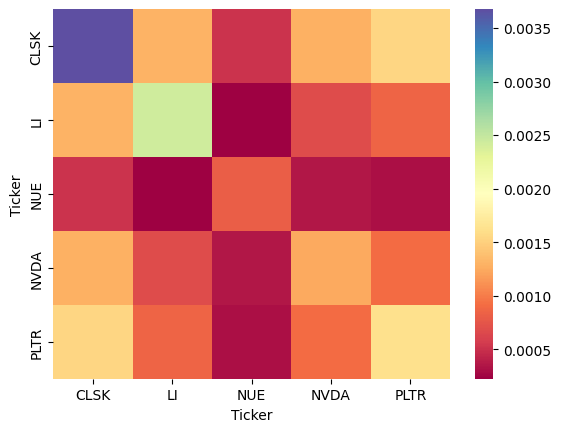

In [27]:
sns.heatmap(cov, cmap='Spectral')
plt.savefig('MVP_corr.png', bbox_inches='tight', pad_inches=0.0)

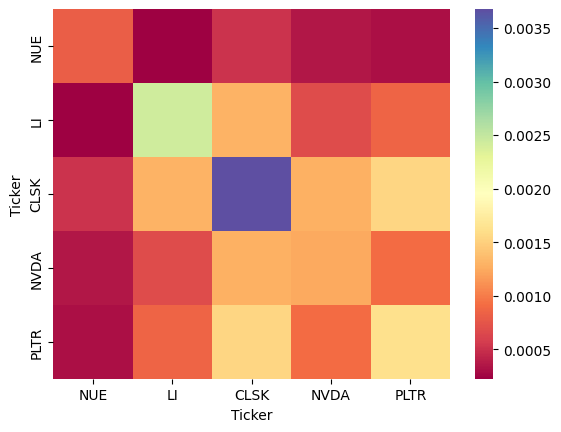

In [28]:
sns.heatmap(q_cova, cmap='Spectral')
plt.savefig('HRP_quasi_diag_corr.png', bbox_inches='tight', pad_inches=0.0)

In [29]:

hrp_ret, hrp_vol = portfolio_stats (portfolios['HRP'], annual_returns, cova)

In [30]:
hrp_sr = (hrp_ret-.02)/hrp_vol
print ("--------------HRP Portfolio------------------\n")
print (f"Portfolio Return: {hrp_ret:.2%}")
print (f"Portfolio Vol: {hrp_vol:.2%}")
print ("Sharpe Ratio: ", hrp_sr)

--------------HRP Portfolio------------------

Portfolio Return: 12.79%
Portfolio Vol: 41.80%
Sharpe Ratio:  0.25823025028119967


###**Backtesting**

[*********************100%%**********************]  5 of 5 completed


Optimized Weights (MVO): [3.87828412e-13 1.13004229e-01 8.86995771e-01 1.87048751e-13
 2.83403599e-13]
Optimized Weights (Risk Parity): [0.13193479 0.16233308 0.28009183 0.226613   0.1990273 ]
Optimized Weights (MDD Constraint): [3.87828412e-13 1.13004229e-01 8.86995771e-01 1.87048751e-13
 2.83403599e-13]


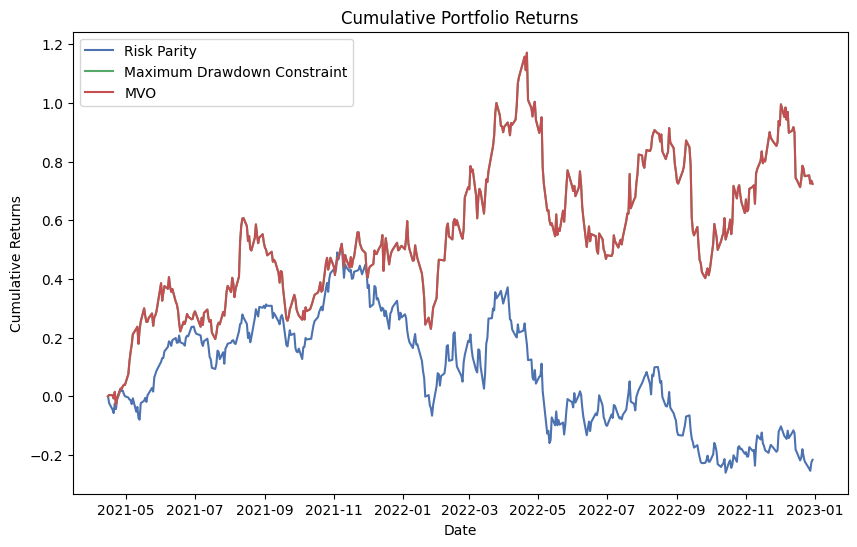

MVO Metrics:
Final Portfolio Value: $172407.93
Portfolio Return: 72.41%
Portfolio Standard Deviation: 42.47%
Sharpe Ratio: 1.59

Maximum Drawdown Constraint Portfolio Metrics:
Final Portfolio Value: $172407.93
Portfolio Return: 72.41%
Portfolio Standard Deviation: 42.47%
Sharpe Ratio: 1.59

Risk Parity Portfolio Metrics:
Final Portfolio Value: $78346.63
Portfolio Return: -21.65%
Portfolio Standard Deviation: 46.44%
Sharpe Ratio: -0.57


In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Tickers for the assets
tickers = ['PLTR', 'LI', 'NUE', 'CLSK', 'NVDA']

# Download historical data
data = yf.download(tickers, start='2021-04-14', end='2022-12-31')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Mean-Variance Optimization
def portfolio_performance(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_std

def neg_sharpe_ratio(weights, returns, risk_free_rate=0.05):
    p_return, p_std = portfolio_performance(weights, returns)
    return -(p_return - risk_free_rate) / p_std

def optimize_portfolio(returns, method='MVO'):
    if method == 'Risk Parity':
        num_assets = len(returns.columns)
        init_weights = num_assets * [1. / num_assets,]
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(num_assets))
        result = minimize(risk_parity_objective, init_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x
    elif method == 'MDD Constraint':
        num_assets = len(returns.columns)
        init_weights = num_assets * [1. / num_assets,]
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                       {'type': 'ineq', 'fun': lambda x: -maximum_drawdown(x, returns)})
        bounds = tuple((0, 1) for _ in range(num_assets))
        result = minimize(neg_sharpe_ratio, init_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x
    else:
        num_assets = len(returns.columns)
        init_weights = num_assets * [1. / num_assets,]
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(num_assets))
        result = minimize(neg_sharpe_ratio, init_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x

# Risk Parity Objective Function
def risk_parity_objective(weights, returns):
    cov_matrix = returns.cov()
    asset_volatility = np.sqrt(np.diag(cov_matrix))
    asset_weighted_volatility = np.dot(weights.T, asset_volatility)
    risk_contribution = np.multiply(weights.T, asset_volatility) / asset_weighted_volatility
    risk_target = np.ones(weights.shape[0]) * (1.0 / weights.shape[0])
    return np.sum(np.square(risk_contribution - risk_target))

# Maximum Drawdown Constraint Function
def maximum_drawdown(weights, returns):
    portfolio_returns = np.dot(returns, weights)
    cum_returns = np.cumprod(1 + portfolio_returns)
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - peak) / peak
    return -np.max(drawdown)

# Optimize portfolio with MVO
weights_MVO = optimize_portfolio(returns, method='MVO')
print("Optimized Weights (MVO):", weights_MVO)

# Optimize portfolio with Risk Parity
weights_risk_parity = optimize_portfolio(returns, method='Risk Parity')
print("Optimized Weights (Risk Parity):", weights_risk_parity)

# Optimize portfolio with Maximum Drawdown Constraint
weights_mdd_constraint = optimize_portfolio(returns, method='MDD Constraint')
print("Optimized Weights (MDD Constraint):", weights_mdd_constraint)

# Backtesting with MVO
initial_investment = 100000
portfolio_values_MVO = [initial_investment]

for i in range(1, len(returns)):
    daily_return = np.dot(returns.iloc[i], weights_MVO)
    portfolio_values_MVO.append(portfolio_values_MVO[-1] * (1 + daily_return))

# Convert portfolio values to a pandas series for easier plotting
portfolio_values_MVO = pd.Series(portfolio_values_MVO, index=returns.index)

# Calculate performance metrics for MVO
cumulative_returns_MVO = (portfolio_values_MVO / initial_investment) - 1
portfolio_return_MVO = (portfolio_values_MVO[-1] / initial_investment - 1)
portfolio_std_MVO = np.std(returns.dot(weights_MVO)) * np.sqrt(252)
risk_free_rate = 0.05
sharpe_ratio_MVO = (portfolio_return_MVO - risk_free_rate) / portfolio_std_MVO

# Backtesting with Risk Parity
initial_investment = 100000
portfolio_values_risk_parity = [initial_investment]

for i in range(1, len(returns)):
    daily_return = np.dot(returns.iloc[i], weights_risk_parity)
    portfolio_values_risk_parity.append(portfolio_values_risk_parity[-1] * (1 + daily_return))

# Convert portfolio values to a pandas series for easier plotting
portfolio_values_risk_parity = pd.Series(portfolio_values_risk_parity, index=returns.index)

# Calculate performance metrics for Risk Parity
cumulative_returns_risk_parity = (portfolio_values_risk_parity / initial_investment) - 1
portfolio_return_risk_parity = (portfolio_values_risk_parity[-1] / initial_investment - 1)
portfolio_std_risk_parity = np.std(returns.dot(weights_risk_parity)) * np.sqrt(252)
sharpe_ratio_risk_parity = (portfolio_return_risk_parity - 0.05) / portfolio_std_risk_parity

# Backtesting with Maximum Drawdown Constraint
portfolio_values_mdd_constraint = [initial_investment]

for i in range(1, len(returns)):
    daily_return = np.dot(returns.iloc[i], weights_mdd_constraint)
    portfolio_values_mdd_constraint.append(portfolio_values_mdd_constraint[-1] * (1 + daily_return))

# Convert portfolio values to a pandas series for easier plotting
portfolio_values_mdd_constraint = pd.Series(portfolio_values_mdd_constraint, index=returns.index)

# Calculate performance metrics for Maximum Drawdown Constraint
cumulative_returns_mdd_constraint = (portfolio_values_mdd_constraint / initial_investment) - 1
portfolio_return_mdd_constraint = (portfolio_values_mdd_constraint[-1] / initial_investment - 1)
portfolio_std_mdd_constraint = np.std(returns.dot(weights_mdd_constraint)) * np.sqrt(252)
sharpe_ratio_mdd_constraint = (portfolio_return_mdd_constraint - 0.05) / portfolio_std_mdd_constraint

# Plotting the cumulative portfolio return graph
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_risk_parity, label='Risk Parity')
plt.plot(cumulative_returns_mdd_constraint, label='Maximum Drawdown Constraint')
plt.plot(cumulative_returns_MVO, label='MVO')
plt.title('Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Print performance metrics for MVO
print("MVO Metrics:")
print(f"Final Portfolio Value: ${portfolio_values_MVO[-1]:.2f}")
print(f"Portfolio Return: {portfolio_return_MVO:.2%}")
print(f"Portfolio Standard Deviation: {portfolio_std_MVO:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_MVO:.2f}")



# Print performance metrics for Maximum Drawdown Constraint
print("\nMaximum Drawdown Constraint Portfolio Metrics:")
print(f"Final Portfolio Value: ${portfolio_values_mdd_constraint[-1]:.2f}")
print(f"Portfolio Return: {portfolio_return_mdd_constraint:.2%}")
print(f"Portfolio Standard Deviation: {portfolio_std_mdd_constraint:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_mdd_constraint:.2f}")



# Print performance metrics for Risk Parity
print("\nRisk Parity Portfolio Metrics:")
print(f"Final Portfolio Value: ${portfolio_values_risk_parity[-1]:.2f}")
print(f"Portfolio Return: {portfolio_return_risk_parity:.2%}")
print(f"Portfolio Standard Deviation: {portfolio_std_risk_parity:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_risk_parity:.2f}")

##Step 3

Next, we perform multiple enhancements to our portfolio -

1. Apply Ledoit Shrinkage to the covariance matrix
2. Denoise the shrunk matrix from (1) using Marchenko-Pastur pdf
3. We derive the optimal portfolio using HRP algorithm to the above matrix

In essence, we are applying multiple methods in sequence to arrive at an optimal portfolio


OrderedDict([('CLSK', 0.0), ('LI', 0.12876), ('NUE', 0.87124), ('NVDA', 0.0), ('PLTR', 0.0)])
Expected annual return: 40.0%
Annual volatility: 42.8%
Sharpe Ratio: 0.89
sse:22663.443610394694
sse:22663.444354834428
sse:58304610795442.14
sse:58188176254756.31
sse:39403.913885555914
sse:39403.910129936616
sse:21422.874470067152
sse:21422.874222330294
sse:21018.263534719357
sse:21018.26339397933
sse:21391.169596957756
sse:21391.170086473932
sse:21005.631682629337
sse:21005.631685335036
sse:21005.62681850006
sse:21005.62681858823
sse:21005.626813379877
sse:21005.62681337978
found errPDFs0.46925909236056895


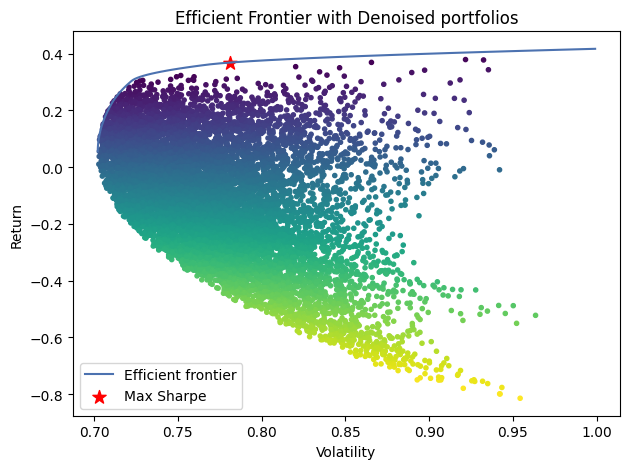

In [32]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

S = CovarianceShrinkage(stock_data).ledoit_wolf()

ef = EfficientFrontier(annual_returns, S, weight_bounds=(0, 1))
aw_weights = ef.max_sharpe()
cleaned_weights_Ledoit_denoised = ef.clean_weights()
print (cleaned_weights_Ledoit_denoised)
ef.portfolio_performance(verbose=True)


corr0 = cov2corr(S)
eVal01, eVec01 = getPCA(corr0)
# code snippet 2.4 - fitting the marcenko-pastur pdf - find variance
eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)
nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)
cov_denoised = denoisedCov(eVal01, eVec01, nFacts0)


ef = EfficientFrontier(annual_returns, cov_denoised, weight_bounds=(0, 1))
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, sr = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ cov_denoised @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with Denoised portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("3_hrp_ef_scatter.png", dpi=200)
plt.show()

In [33]:
print ("--------------Ledoit_wolf + Denoised Covariance Matrix------------------\n")
print (f"Portfolio Return: {ret_tangent:.2%}")
print (f"Portfolio Vol: {std_tangent:.2%}")
print ("Sharpe Ratio: ", (sr))
Ledoit_denoised_weights = np.fromiter(cleaned_weights_Ledoit_denoised.values(), dtype=float)
sortio_denoised = compute_sortino_ratio (daily_returns, Ledoit_denoised_weights)
#_sortio_denoised
print ("Sortino Ratio: ", sortio_denoised)

--------------Ledoit_wolf + Denoised Covariance Matrix------------------

Portfolio Return: 36.88%
Portfolio Vol: 78.10%
Sharpe Ratio:  0.4466238812671832
Sortino Ratio:  1.463592321428998


In [34]:
hrp = HRPOpt(daily_returns, cov_denoised)
hrp.optimize()
hrp_weights = hrp.clean_weights()

print ("--------------Ledoit_wolf + Denoised Covariance Matrix + HRP ------------------\n")
hrp.portfolio_performance(verbose=True);

hrp_weights = np.fromiter(hrp_weights.values(), dtype=float)
sortio_hrp = compute_sortino_ratio (daily_returns, hrp_weights)
#sortio_hrp
print ("Sortino Ratio: ", sortio_hrp)


--------------Ledoit_wolf + Denoised Covariance Matrix + HRP ------------------

Expected annual return: 12.8%
Annual volatility: 41.8%
Sharpe Ratio: 0.26
Sortino Ratio:  0.4915704165658034


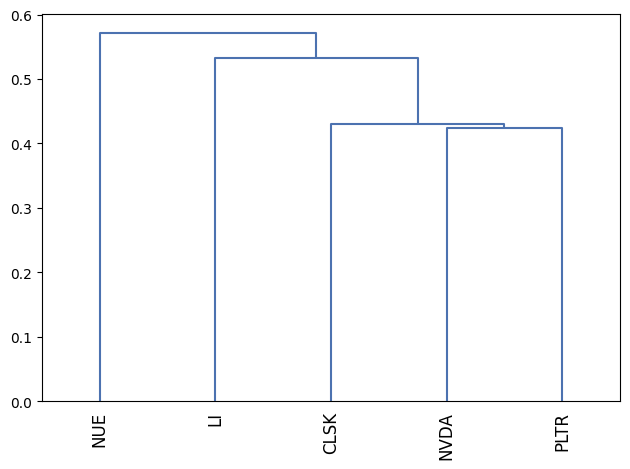

In [35]:
plotting.plot_dendrogram(hrp);

## Step 4 - Train and Test runs

### MVO model out-of-sample test

[*********************100%%**********************]  5 of 5 completed


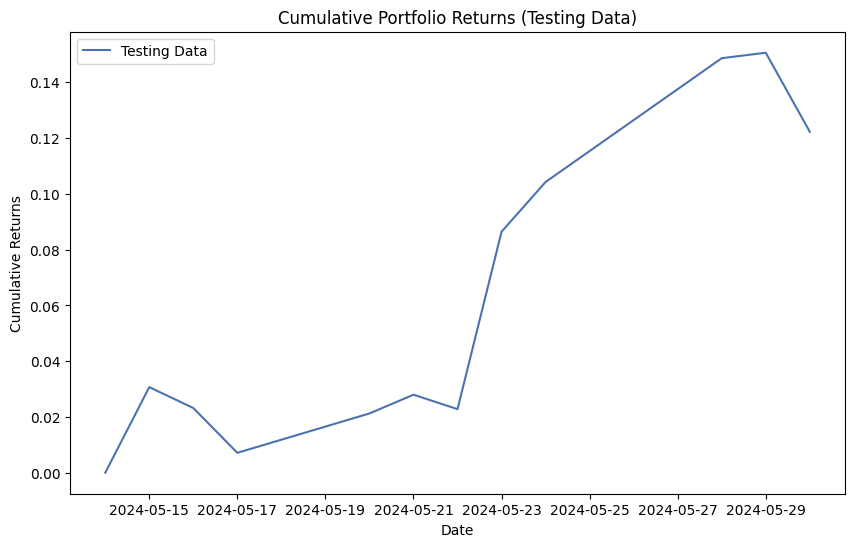


Performance Metrics for Testing Data:
Portfolio Return: 12.23%
Portfolio Standard Deviation: 37.27%
Sharpe Ratio: 0.19


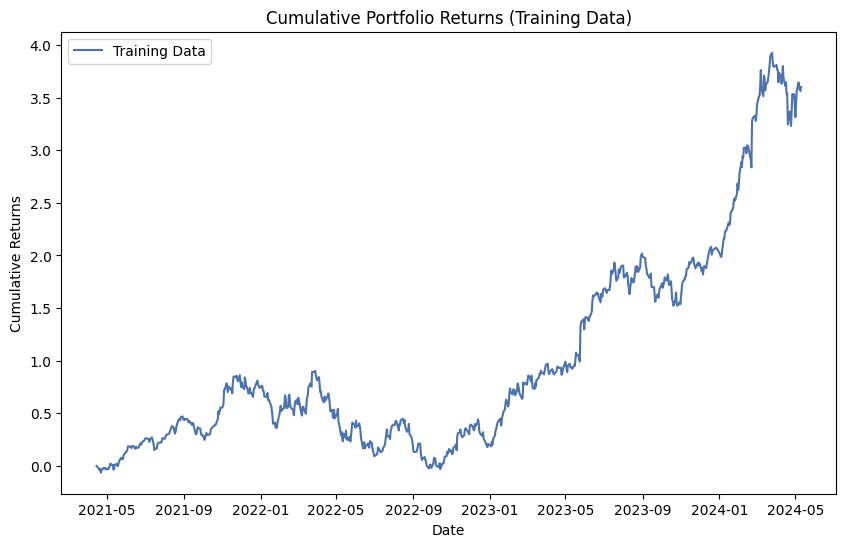


Performance Metrics for Training Data:
Portfolio Return: 360.09%
Portfolio Standard Deviation: 41.08%
Sharpe Ratio: 8.64


In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Tickers for the assets
tickers = ['PLTR', 'LI', 'NUE', 'CLSK', 'NVDA']

# Download historical data
data = yf.download(tickers, start='2021-04-14', end='2024-05-31')['Adj Close']

# Split data into training and testing sets
training_data = data.loc[:'2024-05-12']
testing_data = data.loc['2024-05-13':'2024-05-31']

# Calculate daily returns for training and testing data
training_returns = training_data.pct_change().dropna()
testing_returns = testing_data.pct_change().dropna()

# Mean-Variance Optimization
def portfolio_performance(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_std

def neg_sharpe_ratio(weights, returns, risk_free_rate=0.05):
    p_return, p_std = portfolio_performance(weights, returns)
    return -(p_return - risk_free_rate) / p_std

def optimize_portfolio(returns):
    num_assets = len(returns.columns)
    init_weights = num_assets * [1. / num_assets,]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(neg_sharpe_ratio, init_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Optimize portfolio with Mean-Variance Optimization using training data
weights_training = optimize_portfolio(training_returns)

# Optimize portfolio with Mean-Variance Optimization using testing data
#weights_testing = optimize_portfolio(testing_returns)
weights_testing = weights_training


# Backtesting with Mean-Variance Optimization using testing data
initial_investment = 100000
portfolio_values_testing = [initial_investment]

for i in range(1, len(testing_returns)):
    daily_return = np.dot(testing_returns.iloc[i], weights_training)
    portfolio_values_testing.append(portfolio_values_testing[-1] * (1 + daily_return))

# Convert portfolio values to a pandas series for easier plotting
portfolio_values_testing = pd.Series(portfolio_values_testing, index=testing_returns.index)

# Calculate performance metrics for testing data
cumulative_returns_testing = (portfolio_values_testing / initial_investment) - 1
portfolio_return_testing = (portfolio_values_testing[-1] / initial_investment - 1)
portfolio_std_testing = np.std(testing_returns.dot(weights_training)) * np.sqrt(252)
sharpe_ratio_testing = (portfolio_return_testing - 0.05) / portfolio_std_testing

# Plotting the cumulative portfolio return graph for testing data
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_testing, label='Testing Data')
plt.title('Cumulative Portfolio Returns (Testing Data)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Print performance metrics for testing data
print("\nPerformance Metrics for Testing Data:")
print(f"Portfolio Return: {portfolio_return_testing:.2%}")
print(f"Portfolio Standard Deviation: {portfolio_std_testing:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_testing:.2f}")

# Backtesting with Mean-Variance Optimization using training data
initial_investment = 100000
portfolio_values_training = [initial_investment]

for i in range(1, len(training_returns)):
    daily_return = np.dot(training_returns.iloc[i], weights_training)
    portfolio_values_training.append(portfolio_values_training[-1] * (1 + daily_return))

# Convert portfolio values to a pandas series for easier plotting
portfolio_values_training = pd.Series(portfolio_values_training, index=training_returns.index)

# Calculate performance metrics for training data
cumulative_returns_training = (portfolio_values_training / initial_investment) - 1
portfolio_return_training = (portfolio_values_training[-1] / initial_investment - 1)
portfolio_std_training = np.std(training_returns.dot(weights_training)) * np.sqrt(252)
sharpe_ratio_training = (portfolio_return_training - 0.05) / portfolio_std_training

# Plotting the cumulative portfolio return graph for training data
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_training, label='Training Data')
plt.title('Cumulative Portfolio Returns (Training Data)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Print performance metrics for training data
print("\nPerformance Metrics for Training Data:")
print(f"Portfolio Return: {portfolio_return_training:.2%}")
print(f"Portfolio Standard Deviation: {portfolio_std_training:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_training:.2f}")



## HRP Model Out-of-Sample Test

<ipython-input-24-3481767d364f>:44: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist, 'single')


<Axes: title={'center': 'Out Of Sample Results'}>

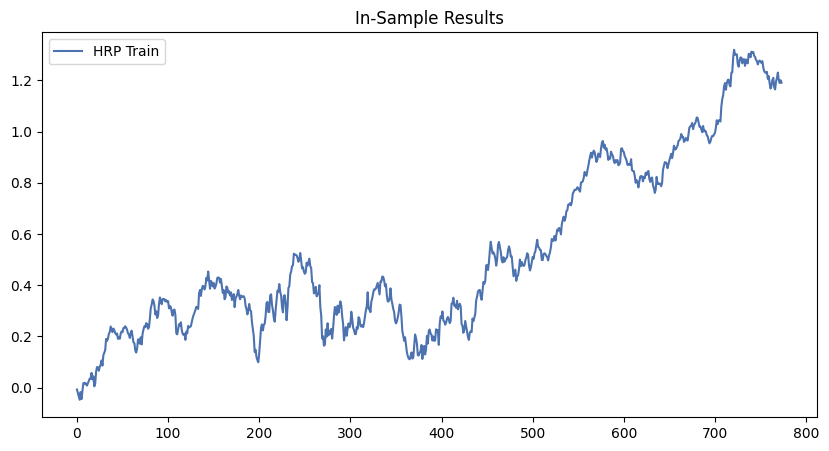

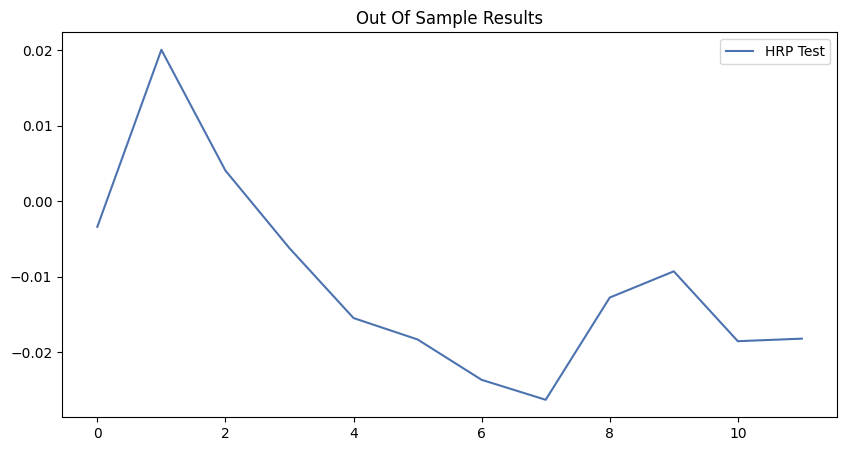

In [37]:
# Get model weight for HRP from training set
cov, corr = daily_returns.cov(), daily_returns.corr()
hrp, _ = getHRP(cov, corr)

# Apply to test set /out of sample set

Insample_Result=pd.DataFrame(np.dot(training_returns, hrp), columns=['HRP Train'])
OutOfSample_Result=pd.DataFrame(np.dot(testing_returns, hrp), columns=['HRP Test'])

Insample_Result.cumsum().plot(figsize=(10, 5), title ="In-Sample Results")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title ="Out Of Sample Results")


In [38]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
HRP Train,0.37314,1.039311


In [39]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
HRP Test,0.172659,-2.210702
